# Analyze RAGIS simulations

In [1]:
from datetime import datetime
import numpy as np
import pylab as plt
import xarray as xr
from glob import glob
import pandas as pd
import os

import seaborn as sns

from pismragis.observations import load_imbie, load_imbie_csv
from pismragis.analysis import resample_ensemble_by_data, sensitivity_analysis
from pismragis.processing import convert_netcdf_to_dataframe, check_file, copy_file
from pismragis.stats import run_stats

In [2]:
n_jobs = 8
norm_year = 1992.0

plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

mass_varname = "SLE (cm)"
mass_uncertainty_varname = "SLE uncertainty (cm)"
discharge_varname = "D (Gt/yr)"
discharge_uncertainty_varname = "D uncertainty (Gt/yr)"
smb_varname = "SMB (Gt/yr)"
smb_uncertainty_varname = "SMB uncertainty (Gt/yr)"


bg_color = "#216779"
bg_color = "w"
sim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][1::]
imbie_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
    
kg2cmsle = 1 / 1e12 * 1.0 / 362.5 / 10.0
gt2cmsle = 1 / 362.5 / 10.0
sigma = 2

## Load IMBIE

In [26]:
# imbie = load_imbie(url="../imbie_dataset_greenland_dynamics-2020_02_28.xlsx")
imbie = load_imbie()
# Glacier and Ice cap bias 30 Gt/yr, add it back
imbie[mass_varname] -= 30 * gt2cmsle
imbie[smb_varname] += 30

glob PISM scalar time series files

In [28]:
data_dir = "../hindcasts"

exps = []

exps.append({
    "Experiment": "frontal melt",
    "proj_dir": "2023_04_ocean_calving_50",
    "scalar_dir": "scalar",
    "processed_dir": "processed",
    "lhs": "gris_ragis_ocean_calving_lhs_50_w_posterior",
}
)

exps.append({
    "Experiment": "thickness calving",
    "proj_dir": "2023_04_thickness_calving_50",
    "scalar_dir": "scalar",
    "processed_dir": "processed",
    "lhs": "gris_ragis_thickness_calving_lhs_50_w_posterior",
}
)

exps.append({
    "Experiment": "no frontal melt",
    "proj_dir": "2023_04_ocean_simple_50",
    "scalar_dir": "scalar",
    "processed_dir": "processed",
    "lhs": "gris_ragis_ocean_simple_lhs_50_w_posterior",
}
)

experiments = []

for exp in exps:

    ens_file = os.path.join(data_dir, exp["proj_dir"], "uq", f"""{exp["lhs"]}.csv""")
    s_dir = os.path.join(data_dir, exp["proj_dir"], exp["scalar_dir"])
    scalar_files = sorted(glob(os.path.join(s_dir, "ts_gris_g*00m_v20*RAGIS_id_*_1980-1-1_2020-1-1.nc")))
    processed_path = os.path.join(data_dir, exp["proj_dir"], exp["processed_dir"])

    for scalar_file in scalar_files:
        if check_file(scalar_file):
            copy_file(scalar_file, processed_path)
        
    processed_files = sorted(glob(os.path.join(processed_path, "ts_gris_g*00m_v20*RAGIS_id_*_1980-1-1_2020-1-1.nc")))

    exp_df = convert_netcdf_to_dataframe(processed_files, resample="yearly", verbose=False, n_jobs=n_jobs)
    exp_df["Experiment"] = exp["Experiment"]
    exp["data_df"] = exp_df
    exp["run_stats"] = run_stats(processed_files, experiment=exp["Experiment"])
    sa_df = sensitivity_analysis(exp_df.dropna(), ensemble_file=ens_file, n_jobs=n_jobs)
    exp["sensitivity_df"] = sa_df
    experiments.append(exp)




Converting netcdf files to pandas.DataFrame
-------------------------------------------


Processing files: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:11<00:00,  4.06it/s]


Conversion finished in 12 seconds
-------------------------------------------
-------------------------------------------



Processing date: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:24<00:00,  1.70it/s]


Program finished in 24 seconds
Converting netcdf files to pandas.DataFrame
-------------------------------------------


Processing files: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:09<00:00,  5.03it/s]


Conversion finished in 10 seconds
-------------------------------------------
-------------------------------------------



Processing date: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:25<00:00,  1.60it/s]


Program finished in 26 seconds
Converting netcdf files to pandas.DataFrame
-------------------------------------------


Processing files: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:10<00:00,  4.56it/s]


Conversion finished in 11 seconds
-------------------------------------------
-------------------------------------------



Processing date: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:25<00:00,  1.61it/s]

Program finished in 25 seconds


Peformace Summary for Experiment frontal melt (47 members)
---------------------------------------------------

processor_hours                   75199.567033
wall_clock_hours                    939.994588
model_years_per_processor_hour        0.037645
dtype: float64
---------------------------------------------------

Peformace Summary for Experiment thickness calving (49 members)
---------------------------------------------------

processor_hours                   103135.122519
wall_clock_hours                    1289.189031
model_years_per_processor_hour         0.035220
dtype: float64
---------------------------------------------------

Peformace Summary for Experiment no frontal melt (48 members)
---------------------------------------------------

processor_hours                   37130.315806
wall_clock_hours                    464.128948
model_years_per_processor_hour        0.052459
dtype: float64
---------------------------------------------------



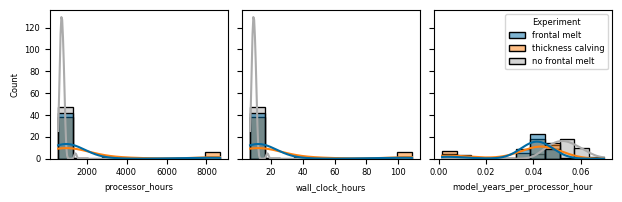

In [29]:
plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

e = experiments[0]["run_stats"]
m_vars = ["processor_hours", "wall_clock_hours", "model_years_per_processor_hour"]
for m in range(len(experiments)):
    e_df = experiments[m]["run_stats"]
    print(f"""Peformace Summary for Experiment {experiments[m]["Experiment"]} ({len(e_df)} members)""")
    print("---------------------------------------------------\n")
    print(e_df.agg({'processor_hours': 'sum', 'wall_clock_hours': "sum", "model_years_per_processor_hour": "mean"}))
    print("---------------------------------------------------\n")

fig, axs = plt.subplots(nrows=1, ncols=len(m_vars), sharey="row", figsize=[6.2, 2.0])
fig.subplots_adjust(wspace=0)


all_run_stats = pd.concat([experiments[k]["run_stats"] for k in range(len(experiments))]).reset_index(drop=True)
[sns.histplot(data=all_run_stats, x=m_var, bins=11, kde=True, hue="Experiment", ax=axs[k]) for k, m_var in enumerate(m_vars)]
axs[0].legend([], [], frameon=False)
axs[1].legend([], [], frameon=False)


fig.tight_layout()
fig.savefig("run_stats.pdf")
!open run_stats.pdf

## Plot

Plot time series of cumulative mass change (cm SLE) and discharge at grounding line (Gt/yr)

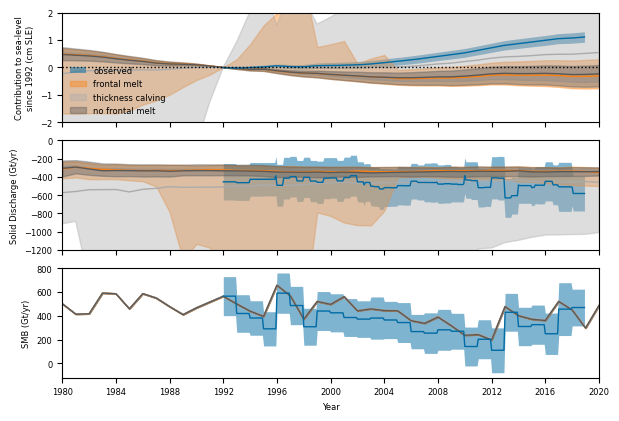

In [30]:
plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

fig, axs = plt.subplots(nrows=3, ncols=1, sharex="col", figsize=(6.2, 4.2))
fig.subplots_adjust(wspace=-0.5, hspace=-0.5)

obs_ci = axs[0].fill_between(imbie["Date"], 
                    (imbie[mass_varname] + sigma * imbie[mass_uncertainty_varname]), 
                    (imbie[mass_varname] - sigma * imbie[mass_uncertainty_varname]), 
                    ls="solid", color=imbie_color, lw=0, alpha=0.5, label="observed")
axs[1].fill_between(imbie["Date"], 
                    (imbie[discharge_varname] + sigma * imbie[discharge_uncertainty_varname]), 
                    (imbie[discharge_varname] - sigma * imbie[discharge_uncertainty_varname]), 
                    ls="solid", color=imbie_color, lw=0, alpha=0.5)
axs[2].fill_between(imbie["Date"], 
                    (imbie[smb_varname] + sigma * imbie[smb_uncertainty_varname]), 
                    (imbie[smb_varname] - sigma * imbie[smb_uncertainty_varname]), 
                    ls="solid", color=imbie_color, lw=0, alpha=0.5)

for k, exp in enumerate(experiments):
    df = exp["data_df"]
    q_05 = df.groupby(by="time").quantile(0.05, numeric_only=True)
    q_50 = df.groupby(by="time").quantile(0.50, numeric_only=True)
    q_95 = df.groupby(by="time").quantile(0.95, numeric_only=True)
    axs[0].plot(q_50.index, q_50[mass_varname], color=sim_colors[k], alpha=1.0, lw=1)
    axs[1].plot(q_50.index, q_50[discharge_varname], color=sim_colors[k], alpha=1.0, lw=1)
    axs[2].plot(q_50.index, q_50[smb_varname], color=sim_colors[k], alpha=1.0, lw=1)

    axs[0].fill_between(q_05.index, q_05[mass_varname], 
                        q_95[mass_varname], color=sim_colors[k], alpha=0.4, lw=1, label=exp["Experiment"])
    axs[1].fill_between(q_05.index, q_05[discharge_varname], 
                        q_95[discharge_varname], color=sim_colors[k], alpha=0.4, lw=1)
    axs[2].fill_between(q_05.index, q_05[smb_varname], 
                        q_95[smb_varname], color=sim_colors[k], alpha=0.4, lw=1)

axs[0].plot(imbie["Date"], imbie[mass_varname], color=imbie_color, lw=1)
axs[1].plot(imbie["Date"], imbie[discharge_varname], color=imbie_color, lw=1)
axs[2].plot(imbie["Date"], imbie[smb_varname], color=imbie_color, lw=1)



fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)

axs[0].axhline(0, color="k", ls="dotted", lw=1.0)
axs[0].set_xlabel("")
axs[0].set_ylabel("Contribution to sea-level\nsince 1992 (cm SLE)")
axs[-1].set_xlabel("Year")
axs[1].set_ylabel("Solid Discharge (Gt/yr)")
axs[2].set_ylabel("SMB (Gt/yr)")
axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2020-1-1"))
axs[0].set_ylim(-2.0, 2.0)
axs[1].set_ylim(-1200, 0)
#axs[1].set_ylim(-1000, 100)

legend = axs[0].legend(loc="lower left")
legend.get_frame().set_linewidth(0.0)
legend.get_frame().set_alpha(0.0)
fig.tight_layout()
fig.savefig("ragis-comp_scalar.pdf")
!open ragis-comp_scalar.pdf

## Plot sensitivity index

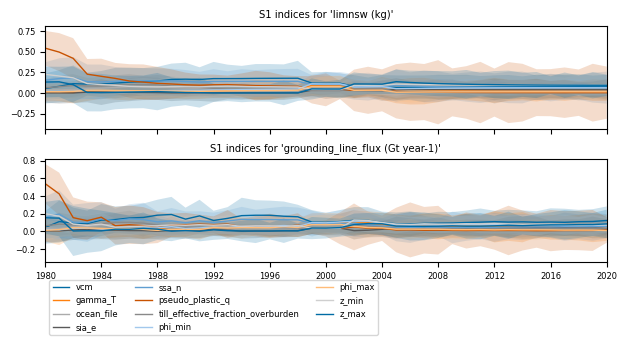

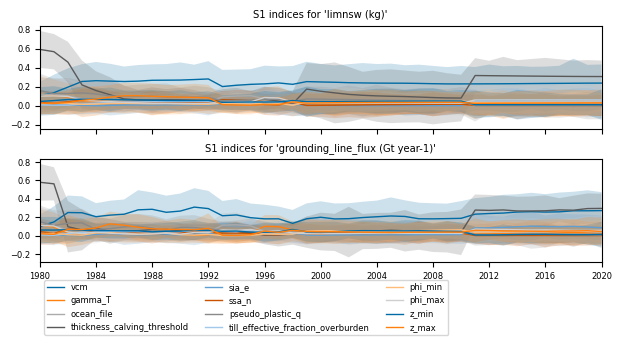

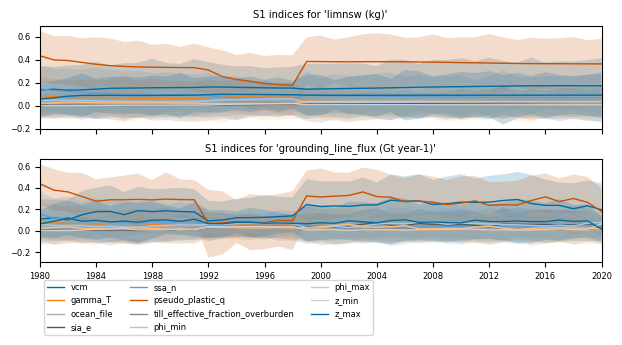

In [31]:
plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")


for e in experiments:
    sa_df = e["sensitivity_df"]
    si = "S1"
    outfile = f"""{e["lhs"]}.pdf"""
    fig, axs = plt.subplots(
        2,
        1,
        sharex="col",
        figsize=[6.2, 3.8],
    )
    fig.subplots_adjust(bottom=0.0)
    for k, m_var in enumerate(["limnsw (kg)", "grounding_line_flux (Gt year-1)"]):
        m_df = sa_df[sa_df["Variable"] == m_var]
        ax = axs.ravel()[k]
        p_df = m_df[m_df["Si"] == si].drop(columns=["Si", "Variable"]).set_index("Date")
        p_conf_df = m_df[m_df["Si"] == si + "_conf"].drop(columns=["Si"])

        [
            ax.plot(p_df.index, p_df[v], lw=1, label=v)
            for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        ]

        [
            ax.fill_between(
                p_df.index,
                p_df[v].values - p_conf_df[v].values,
                p_df[v].values + p_conf_df[v].values,
                alpha=0.2,
                lw=0,
            )
            for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        ]
        ax.set_xlim(datetime(1980, 1, 1), datetime(2020, 1, 1))
        lgd = ax.set_title(f"{si} indices for '{m_var}'")
    legend = axs[-1].legend(loc="lower left", ncols=3, bbox_to_anchor=(0, -0.75))
    fig.tight_layout()
    fig.savefig(f"{si}_{outfile}")


In [67]:
m_e = experiments[2]["data_df"]
ragis_calib, weights = resample_ensemble_by_data_o(imbie, m_e, 
                                        fudge_factor=3, verbose=True)
calib_exps = ragis_calib["id"].unique()
print(calib_exps)

1 1992.0 6.600 48.844 0.000
1 1992.08333333333 13.200 69.076 10.226
1 1992.16666666667 19.800 84.600 20.452
1 1992.25 26.400 97.688 30.678
1 1992.33333333333 33.000 109.218 40.905
1 1992.41666666667 39.600 119.642 51.131
1 1992.5 46.200 129.229 61.357
1 1992.58333333333 52.800 138.151 71.583
1 1992.66666666667 59.400 146.531 81.809
1 1992.75 66.000 154.458 92.035
1 1992.83333333333 72.600 161.997 102.261
1 1992.91666666667 79.200 169.200 112.488
1 1993.0 72.908 176.133 122.714
1 1993.08333333333 66.617 182.803 131.000
1 1993.16666666667 60.325 189.238 139.286
1 1993.25 54.033 195.462 147.572
1 1993.33333333333 47.742 201.493 155.858
1 1993.41666666667 41.450 207.349 164.144
1 1993.5 35.158 213.044 172.430
1 1993.58333333333 28.867 218.591 180.716
1 1993.66666666667 22.575 224.001 189.001
1 1993.75 16.283 229.283 197.287
1 1993.83333333333 9.992 234.446 205.573
1 1993.91666666667 3.700 239.497 213.859
1 1994.0 -2.700 244.444 222.145
1 1994.08333333333 -9.100 249.294 218.096
1 1994.16666

49 1992.0 6.600 48.844 0.000
49 1992.08333333333 13.200 69.076 9.336
49 1992.16666666667 19.800 84.600 18.672
49 1992.25 26.400 97.688 28.008
49 1992.33333333333 33.000 109.218 37.344
49 1992.41666666667 39.600 119.642 46.681
49 1992.5 46.200 129.229 56.017
49 1992.58333333333 52.800 138.151 65.353
49 1992.66666666667 59.400 146.531 74.689
49 1992.75 66.000 154.458 84.025
49 1992.83333333333 72.600 161.997 93.361
49 1992.91666666667 79.200 169.200 102.697
49 1993.0 72.908 176.133 112.033
49 1993.08333333333 66.617 182.803 119.615
49 1993.16666666667 60.325 189.238 127.197
49 1993.25 54.033 195.462 134.779
49 1993.33333333333 47.742 201.493 142.361
49 1993.41666666667 41.450 207.349 149.943
49 1993.5 35.158 213.044 157.524
49 1993.58333333333 28.867 218.591 165.106
49 1993.66666666667 22.575 224.001 172.688
49 1993.75 16.283 229.283 180.270
49 1993.83333333333 9.992 234.446 187.852
49 1993.91666666667 3.700 239.497 195.434
49 1994.0 -2.700 244.444 203.016
49 1994.08333333333 -9.100 249.

/var/folders/5v/ygbxqh8j17l06blqkg6tl26c0000gn/T/ipykernel_15859/933679384.py:80: RuntimeWarning: overflow encountered in exp
  weights = np.exp(w)
/var/folders/5v/ygbxqh8j17l06blqkg6tl26c0000gn/T/ipykernel_15859/933679384.py:81: RuntimeWarning: invalid value encountered in divide
  weights /= weights.sum()


ValueError: probabilities contain NaN

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(12, 8))
fig.subplots_adjust(wspace=0.0, hspace=0.0)

q_5 = ragis_calib.groupby(by="Year").quantile(0.05, numeric_only=True)
q_16 = ragis_calib.groupby(by="Year").quantile(0.16, numeric_only=True)
q_50 = ragis_calib.groupby(by="Year").quantile(0.50, numeric_only=True)
q_84 = ragis_calib.groupby(by="Year").quantile(0.84, numeric_only=True)
q_95 = ragis_calib.groupby(by="Year").quantile(0.95, numeric_only=True)
for exp in m_e:
    print(exp)
    e = m_e[m_e["id"] == exp]
    axs[0].plot(e["Year"], e[mass_varname], color="k", lw=1)
    print(e)
    axs[1].plot(e["Year"], e[discharge_varname], color="k", lw=1)

for exp in calib_exps:
    e = m_e[m_e["id"] == exp]
    axs[0].plot(e["Year"], e[mass_varname], lw=1)
    axs[1].plot(e["Year"], e[discharge_varname], lw=1)

axs[0].fill_between(q_50.index, q_16[mass_varname], q_84[mass_varname], color="w")
axs[0].fill_between(imbie["Year"], 
                    (imbie[mass_varname] + sigma * imbie[mass_uncertainty_varname]), 
                    (imbie[mass_varname] - sigma * imbie[mass_uncertainty_varname]), 
                    ls="solid", lw=0, alpha=0.35, label="2-$\sigma$ IMBIE")
axs[1].fill_between(imbie["Year"], 
                    (imbie[discharge_varname] + sigma * imbie[discharge_uncertainty_varname]), 
                    (imbie[discharge_varname] - sigma * imbie[discharge_uncertainty_varname]), 
                    ls="solid", lw=0, alpha=0.35, color=imbie_color)


axs[0].set_xlim(1992, 2020)
axs[0].set_ylim(0, 2)
fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)




In [39]:
from scipy.interpolate import interp1d
from tqdm import tqdm


In [ ]:
np.array([  634.45744104  -235.12952599 -1167.45917464  -531.87414125
  -904.57676904    91.04033758   722.82730577   114.16742036
   423.55949261   625.02532308  -293.90580578   647.25631402
  -586.31879794 -1381.01064481   349.68201297   716.26847793
   363.33248697 -1011.23876497   -48.85983816   406.46475582
   605.17371227  -949.29602232  -988.06082517  -534.95763144
   405.57114816  -986.00865133  -649.38528098   665.06762932
   625.46368323   385.91494928 -1067.25259603  1053.83389006
   230.25552736  -390.24453682   176.72057353 -1066.75620664
  -303.09711807   312.49178881   942.86270865   783.1536109
   111.79503873  -139.82581505   570.4991376   -757.75426472
   586.62399324    39.56232318   879.51778518   524.42354351]
[  634.45744104  -235.12952599 -1167.45917464  -531.87414125
  -904.57676904    91.04033758   722.82730577   114.16742036
   423.55949261   625.02532308  -293.90580578   647.25631402
  -586.31879794 -1381.01064481   349.68201297   716.26847793
   363.33248697 -1011.23876497   -48.85983816   406.46475582
   605.17371227  -949.29602232  -988.06082517  -534.95763144
   405.57114816  -986.00865133  -649.38528098   665.06762932
   625.46368323   385.91494928 -1067.25259603  1053.83389006
   230.25552736  -390.24453682   176.72057353 -1066.75620664
  -303.09711807   312.49178881   942.86270865   783.1536109
   111.79503873  -139.82581505   570.4991376   -757.75426472
   586.62399324    39.56232318   879.51778518   524.42354351])

In [ ]:
np.exp(weights)

In [ ]:
imbie

In [ ]:
e

In [ ]:
calib_exps

In [ ]:
e

In [ ]:
m_e

In [ ]:
experiments[1]["data_df"]

In [ ]:
m_e = experiments[2]["data_df"]

In [ ]:
m_e

In [57]:
def resample_ensemble_by_data_o(
    observed: pd.DataFrame,
    simulated: pd.DataFrame,
    id_var: str = "id",
    calibration_start: float = 1992.0,
    calibration_end: float = 2017.0,
    fudge_factor: float = 3,
    n_samples: int = 100,
    verbose: bool = False,
    m_var: str = "Mass (Gt)",
    m_var_std: str = "Mass uncertainty (Gt)",
) -> pd.DataFrame:
    """
    Resampling algorithm by Douglas C. Brinkerhoff


    Parameters
    ----------
    observed : pandas.DataFrame
        A dataframe with observations
    simulated : pandas.DataFrame
        A dataframe with simulations
    calibration_start : float
        Start year for calibration
    calibration_end : float
        End year for calibration
    fudge_factor : float
        Tolerance for simulations. Calculated as fudge_factor * standard deviation of observed
    n_samples : int
        Number of samples to draw.

    """

    observed_calib_time = (observed["Year"] >= calibration_start) & (
        observed["Year"] <= calibration_end
    )
    observed_calib_period = observed[observed_calib_time]
    observed_interp_mean = interp1d(
        observed_calib_period["Year"], observed_calib_period[m_var]
    )
    observed_interp_std = interp1d(
        observed_calib_period["Year"], observed_calib_period[m_var_std]
    )
    simulated_calib_time = (simulated["Year"] >= calibration_start) & (
        simulated["Year"] <= calibration_end
    )
    simulated_calib_period = simulated[simulated_calib_time]

    resampled_list = []
    log_likes = []
    experiments = sorted(simulated_calib_period[id_var].unique())
    evals = []
    for i in experiments:
        exp_ = simulated_calib_period[(simulated_calib_period[id_var] == i)]
        exp_interp = interp1d(exp_["Year"], exp_[m_var])
        log_like = 0.0
        for year, observed_mean, observed_std in zip(
            observed_calib_period["Year"],
            observed_calib_period[m_var],
            observed_calib_period[m_var_std],
        ):
            try:
                observed_std *= fudge_factor
                exp_mean = exp_interp(year)

                log_like -= 0.5 * (
                    (exp_mean - observed_mean) / observed_std
                ) ** 2 + 0.5 * np.log(2 * np.pi * observed_std**2)
            except ValueError:
                pass
        if log_like != 0:
            evals.append(i)
            log_likes.append(log_like)
            if verbose:
                print(f"Experiment {i:.0f}: {log_like:.2f}")
    experiments = np.array(evals)
    w = np.array(log_likes)
    w -= w.mean()
    weights = np.exp(w)
    weights /= weights.sum()
    resampled_experiments = np.random.choice(experiments, n_samples, p=weights)
    new_frame = []
    for i in resampled_experiments:
        new_frame.append(simulated[(simulated[id_var] == i)])
    simulated_resampled = pd.concat(new_frame)
    resampled_list.append(simulated_resampled)

    simulated_resampled = pd.concat(resampled_list)

    return simulated_resampled


In [50]:
def resample_ensemble_by_data(
    observed: pd.DataFrame,
    simulated: pd.DataFrame,
    id_var: str = "id",
    calibration_start: float = 1992.0,
    calibration_end: float = 2017.0,
    fudge_factor: float = 3,
    n_samples: int = 100,
    verbose: bool = False,
    m_var: str = "Mass (Gt)",
    m_var_std: str = "Mass uncertainty (Gt)",
) -> pd.DataFrame:
    """
    Resampling algorithm by Douglas C. Brinkerhoff


    Parameters
    ----------
    observed : pandas.DataFrame
        A dataframe with observations
    simulated : pandas.DataFrame
        A dataframe with simulations
    calibration_start : float
        Start year for calibration
    calibration_end : float
        End year for calibration
    fudge_factor : float
        Tolerance for simulations. Calculated as fudge_factor * standard deviation of observed
    n_samples : int
        Number of samples to draw.

    """

    observed_calib_time = (observed["Year"] >= calibration_start) & (
        observed["Year"] <= calibration_end
    )
    observed_calib_period = observed[observed_calib_time]
    observed_interp_mean = interp1d(
        observed_calib_period["Year"], observed_calib_period[m_var]
    )
    observed_interp_std = interp1d(
        observed_calib_period["Year"], observed_calib_period[m_var_std]
    )
    simulated_calib_time = (simulated["Year"] >= calibration_start) & (
        simulated["Year"] <= calibration_end
    )
    simulated_calib_period = simulated[simulated_calib_time]

    resampled_list = []
    log_likes = []
    experiments = sorted(simulated_calib_period[id_var].unique())
    evals = []
    for i in experiments:
        exp_ = simulated_calib_period[(simulated_calib_period[id_var] == i)]
        exp_interp = interp1d(exp_["Year"], exp_[m_var])
        log_like = 0.0
        for year, exp_mean in zip(exp_["Year"], exp_[m_var]):
            try:
                observed_mean = observed_interp_mean(year)
                observed_std = observed_interp_std(year) * fudge_factor
                log_like -= 0.5 * (
                    (exp_mean - observed_mean) / observed_std
                ) ** 2 + 0.5 * np.log(2 * np.pi * observed_std**2)
                print(i, year, f"{observed_mean:.3f}", f"{observed_std:.3f}", f"{exp_mean:.3f}")

            except ValueError:
                pass
        if log_like != 0:
            evals.append(i)
            log_likes.append(log_like)
            if verbose:
                print(f"Experiment {i:.0f}: {log_like:.2f}")
    experiments = np.array(evals)
    w = np.array(log_likes)
    w -= w.mean()
    weights = np.exp(w)
    weights /= weights.sum()
    resampled_experiments = np.random.choice(experiments, n_samples, p=weights)
    new_frame = []
    for i in resampled_experiments:
        new_frame.append(simulated[(simulated[id_var] == i)])
    simulated_resampled = pd.concat(new_frame)
    resampled_list.append(simulated_resampled)

    simulated_resampled = pd.concat(resampled_list)

    return simulated_resampled, weights